In [88]:
import torch
import time
import matplotlib.pyplot as plt
import non_local_boxes
from IPython.display import clear_output   # in order to clear the print output

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gradient Descent

In [2]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [3]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [4]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

# Test in some triangle

In [5]:
def new_color(value, threshold, k, max_box_power_GD):
    if value > threshold:
        return (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return "orangered"

In [6]:
def next_Q(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        color_point = new_color(value, threshold, k, max_box_power_GD)
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, color_point

In [7]:
def test_box_power(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        color_point = new_color(value, threshold, k, max_box_power_GD)

    return color_point

In [15]:
def draw_triangle(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            color_point = new_color(value, threshold, 0, max_box_power_GD)
            best_wiring = non_local_boxes.utils.random_wiring(n)

            for k in range(max_box_power_GD-1):
                Q, best_wiring, color_point = next_Q(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold)
                color_point = test_box_power(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold)

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

0.75000006
0.7499806
0.7499902
0.75000006
0.75000006
0.75000006
0.7500002
0.7500001
0.7500001
0.75000006
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500001
0.7500002
0.7500001
0.7500001
0.75000006
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500002
0.7500001
0.7500001
0.7500002
0.7500001
0.7500002
0.7500001
0.75
0.7500001
0.74999475
0.7499799
0.75000006
0.7522367
0.7554281
0.7548935
0.75664574
0.7542687
0.7530437
0.75445557
0.75372875
0.754909
0.7529647
0.7529488
0.75380945
0.75246286
0.7542176
0.75137424
0.7523409
0.7515055
0.75149655
0.7510591
0.7510626
0.7515917
0.75208
0.75183666
0.75233966
0.7517601
0.7520471
0.7527136
0.7528927
0.752084
0.75332165
0.7537654
0.7525747
0.75240755
0.75304645
0.7534173
0.75344944
0.7532413
0.7530254
0.7548125
0.75392103
0.76531756
0.76120794
0.7616103
0.76090986
0.7646886
0.76893353
0.7601261
0.7612069
0.7607262
0.75904506
0.76203585
0.75727415
0.7578641
0.75994736
0.75691783
0.7565749
0.75661

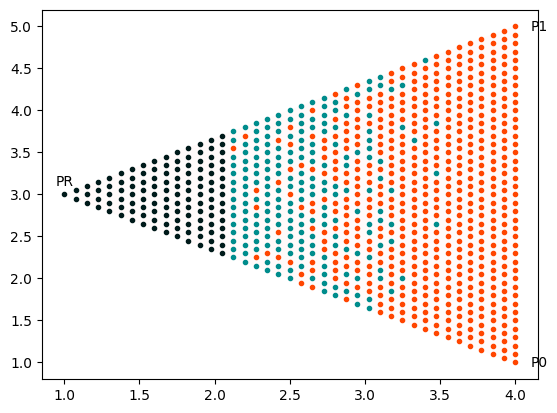

In [16]:
draw_triangle(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 2,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

# Naive test in some triangle

In [17]:
def draw_triangle_naive(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    W_random = non_local_boxes.utils.random_wiring(n)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))

            if value > threshold:
                color_point = (0, 0.1, 0.1)
                print(value)
            else:
                # Given a box P, we look for the W maximizing P x_W P
                W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
                list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
                index, value = max(enumerate(list), key=lambda x: x[1])
                best_wiring = W[:,index].detach()
                best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
                print(value)
                
                for k in range(max_box_power+1):
                    if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                        color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                        break
                    Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

0.7500001
0.7499304
0.7499342
0.75
0.75
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500001
0.7500001
0.7500001
0.7500001
0.75000006
0.7500001
0.75000006
0.7500001
0.7500001
0.7500002
0.75000006
0.75000006
0.7500001
0.7500001
0.7500002
0.7500001
0.75000006
0.7500002
0.7500001
0.7500002
0.7500001
0.75000006
0.7500001
0.7500001
0.7500001
0.75000006
0.75193244
0.7529229
0.7536321
0.7536124
0.7535076
0.7533571
0.7531809
0.75299186
0.7527925
0.7525935
0.75238955
0.75218785
0.75258696
0.75302684
0.75325
0.75310856
0.7529678
0.75282806
0.7526642
0.7524988
0.7523371
0.7521625
0.7519924
0.7518137
0.7516368
0.75144184
0.7510932
0.75076115
0.7509567
0.7517487
0.7519201
0.7521122
0.75251293
0.7529056
0.75296867
0.75275004
0.75291437
0.75307757
0.753216
0.75264174
0.76167667
0.76100653
0.7608101
0.76056075
0.76010996
0.7596702
0.7592409
0.75882107
0.7584113
0.7580114
0.7576198
0.75723666
0.75686115
0.7567959
0.7568179
0.7565144
0.75621355
0

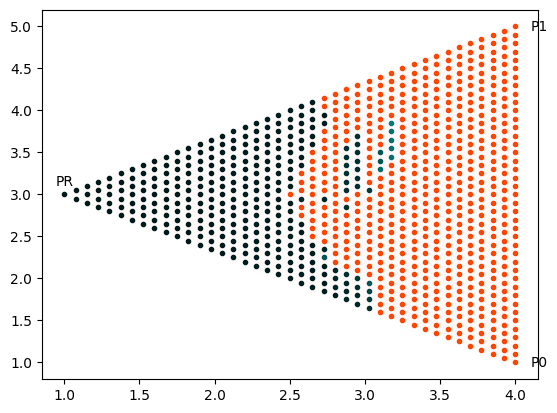

In [18]:
draw_triangle_naive(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

# With blue cones: it's dangerous because the triangle is not stable under all wirings

We check if the starting box $P$ is a in the blue cone of another box, but we don't check the powers of $P$ because they could be outside of the triangle.

In [50]:
def is_in_a_blue_cone(xP, yP, blue_points, X): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point in blue_points:
        x0, y0 = point
        f = lambda x : X[1,1]*(x-x0)/(X[1,0]-x0) + y0*(x-X[1,0])/(x0-X[1,0])  # Lagrange interpolation
        g = lambda x : X[2,1]*(x-x0)/(X[2,0]-x0) + y0*(x-X[2,0])/(x0-X[2,0])  # Lagrange interpolation
        if yP <= f(xP) and yP >= g(xP):
            return True
    return False

In [51]:
def new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD):
    if value > threshold:
        blue_points.append((xP,yP))
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [57]:
def next_Q_with_blue_cones(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [69]:
def test_box_power_with_blue_cones(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)

    return blue_points, color_point

In [59]:
def draw_triangle_with_blue_cones(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            if is_in_a_blue_cone(xP, yP, blue_points, X):
                color_point = (0, 0.1, 0.1)
            else:
                Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                value = float(non_local_boxes.evaluate.h_flat(Q))
                blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                best_wiring = non_local_boxes.utils.random_wiring(n)

                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                    blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

0.75000006
0.75
0.7499202
0.7497943
0.7499442
0.7457031
0.74999994
0.7499999
0.75
0.74934787
0.75000006
0.7397367
0.7500002
0.74938864
0.7500001
0.74737203
0.7500001
0.74783003
0.7500001
0.7492931
0.7500001
0.75
0.7500002
0.7500002
0.7500001
0.7499365
0.7500001
0.75000006
0.75000006
0.75
0.7500001
0.75000006
0.7500002
0.7497463
0.7500001
0.7498485
0.7500001
0.74549955
0.75000006
0.7499999
0.7500001
0.75000006
0.75000006
0.7399123
0.7500001
0.75000006
0.7500001
0.7487913
0.7500002
0.7498943
0.7500001
0.75
0.75000006
0.74993634
0.7500001
0.749914
0.7500001
0.75000006
0.7500001
0.74733925
0.7500001
0.7409608
0.7500001
0.7383635
0.7500001
0.74571985
0.75000006
0.7457053
0.7500001
0.74679327
0.75000006
0.7493375
0.74999994
0.748725
0.75000006
0.7493117
0.7498448
0.74903095
0.7499513
0.74076915
0.75000006
0.74999994
0.7496078
0.7471047
0.7502327
0.748549
0.75103
0.74172324
0.75000995
0.7484163
0.7514838
0.7520612
0.7502226
0.74727976
0.75015867
0.740878
0.7507062
0.7488354
0.75125253
0.74987

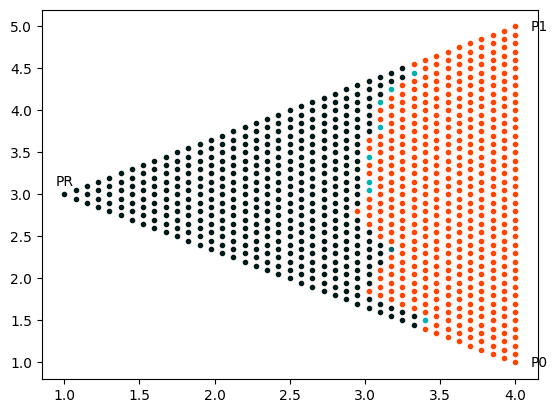

In [62]:
draw_triangle_with_blue_cones(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 10,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

# With the rerun option

We run again the gradient descent, but we keep the list `blue_points`.

In [90]:
def draw_triangle_with_rerun(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            for j in range(box_grid_size-i+1):
                alpha, beta = i/box_grid_size, j/box_grid_size
                xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
                P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
                color_point = "orangered"

                if is_in_a_blue_cone(xP, yP, blue_points, X):
                    color_point = (0, 0.1, 0.1)
                else:
                    Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                    best_wiring = non_local_boxes.utils.random_wiring(n)

                    for k in range(max_box_power_GD-1):
                        Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                        blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

                plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

 ----- Run number  0
0.75000006
0.75
0.74993414
0.749787
0.7499493
0.75
0.749967
0.74780685
0.75
0.7456387
0.75000006
0.75
0.7500002
0.74799085
0.75000006
0.74999994
0.7500001
0.7421837
0.75000006
0.7490968
0.7500001
0.7405061
0.7500002
0.7500001
0.7500001
0.74449
0.7500001
0.7498745
0.75000006
0.71324885
0.7500001
0.7367483
0.7500002
0.75
0.7500001
0.75000006
0.7500001
0.7443875
0.75000006
0.7499887
0.75000006
0.7478524
0.7500001
0.7499193
0.7500001
0.75000006
0.7500001
0.7499607
0.7500002
0.7500002
0.7500001
0.75000006
0.7500001
0.7341603
0.7500001
0.74051875
0.7500001
0.74106205
0.7500001
0.7455827
0.7500001
0.7463045
0.75000006
0.74996173
0.7500002
0.7455293
0.75000006
0.75
0.7500001
0.7468224
0.75000006
0.7499684
0.75
0.7494487
0.75
0.7459717
0.74995273
0.7440734
0.7499339
0.74982697
0.75000006
0.75
0.7498505
0.7509438
0.7500559
0.74297774
0.7502769
0.7505371
0.75042576
0.74952394
0.7505763
0.7472511
0.75190485
0.74618125
0.75263447
0.75186193
0.7511743
0.74809414
0.75048333
0.748

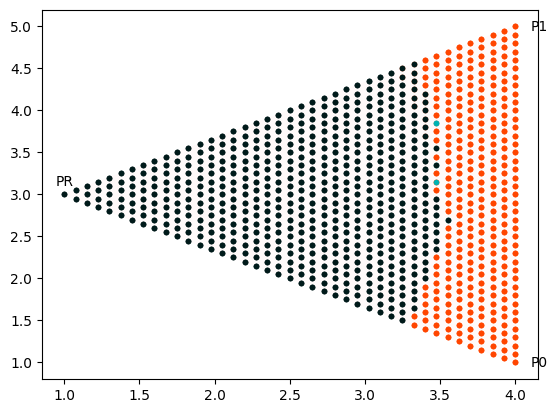

In [67]:
draw_triangle_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 3
)

# Draw segment

In [93]:
def is_in_a_blue_cone_1D(value, blue_points): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point_value in blue_points:
        if value>=point_value:
            return True
    return False

In [94]:
def new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W):
    if value > threshold:
        blue_points.append(valueP)
        print(W)
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [99]:
def next_Q_1D(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, best_wiring[:,0])
        print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [100]:
def test_box_power_1D(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W0[:,0])

    return blue_points, color_point

In [103]:
def draw_segment_with_rerun(Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        #clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            alpha = i/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha)
            P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            valueP = float(non_local_boxes.evaluate.h_flat(Q))
            value = valueP
            blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, 0, max_box_power_GD, "No wiring")
            best_wiring = non_local_boxes.utils.random_wiring(n)

            if is_in_a_blue_cone_1D(value, blue_points):
                color_point = (0, 0.1, 0.1)
            else:
                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_1D(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP)
                    blue_points, color_point = test_box_power_1D(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()

 ----- Run number  0
0.75000006
0.75
0.75
0.75
0.74973744
0.74942744
0.7498343
0.7499125
0.751633
0.7488645
0.7480456
0.74687636
0.75160384
0.7470382
0.74376833
0.7461335
0.75368387
0.75442356
0.755778
0.7567547
0.76223224
0.75961363
0.75685346
0.7529912
0.7647772
0.76702744
0.76404244
0.7644338
0.77621907
0.7437323
0.74949646
0.7505528
0.7799173
0.7772559
0.7750369
0.7729526
0.78358305
0.7824258
0.7820893
0.78208935
0.7889693
0.79037994
0.7951813
0.798076
0.79586303
0.7810028
0.755988
0.7547775
0.82570535
0.8180048
0.836953
0.8280345
0.81224436
0.8131602
0.8261584
0.8252333
0.8210206
0.8081282
0.7999747
0.79828465
0.8270653
0.812525
0.83129966
0.82113993
0.8491695
0.8703678
0.87936425
0.88006556
0.85090405
0.8234955
0.81391436
0.80541444
0.8570311
0.841375
0.85902345
0.8429199
0.85945326
0.84188974
0.82785404
0.8208177
0.8683008
0.88396835
0.88451684
0.87699926
0.87631696
0.85484195
0.86880827
0.84925807
0.87653977
0.85334086
0.8640121
0.84310985
0.88152725
0.856235
0.86347944
0.84152

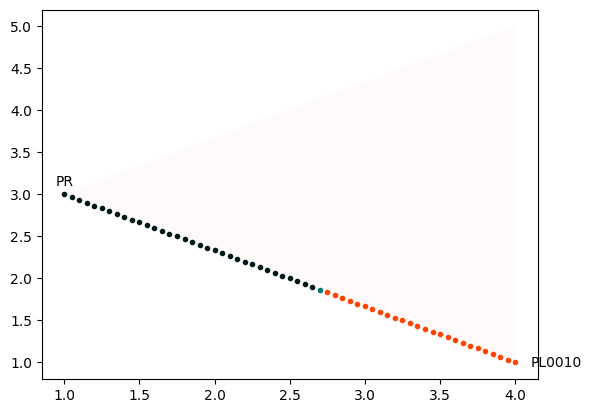

In [102]:
draw_segment_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(0,0,1,0),
    Box2_name = "PL0010",
    box_grid_size = 60,
    max_box_power_GD = 5,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 1
)

In [107]:
W_result = torch.tensor([1., 1., 0., 0., 
    1., 1., 0., 0., 
    1., 1., 0., 1., 
    0., 1., 0., 1., 
    0., 1., 1., 0., 1., 0., 0., 1., 
    1., 0., 1., 0., 0., 1., 0., 1.])

In [115]:
def test_wiring_segment(W, Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        alpha = i/box_grid_size
        P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
        color_point = "orangered"

        Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
        value = float(non_local_boxes.evaluate.h_flat(Q))
        print(value)
        if value > threshold:
                color_point = (0, 0.1, 0.1)
        else:
            if value != 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

        plt.plot(X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()


0.75
0.7541667819023132
0.7583332657814026
0.7625000476837158
0.7666666507720947
0.770833432674408
0.7749999761581421
0.7791666984558105
0.7833333015441895
0.7875000238418579
0.7916665077209473
0.7958333492279053
0.7999999523162842
0.8041666746139526
0.8083332180976868
0.8125
0.8166667819023132
0.8208332657814026
0.8250001072883606
0.8291666507720947
0.833333432674408
0.8374999761581421
0.8416666984558105
0.8458333015441895
0.8500000238418579
0.8541665077209473
0.8583333492279053
0.8624998927116394
0.8666666746139526
0.8708332180976868
0.875
0.8791666030883789
0.8833333253860474
0.8875001072883606
0.8916666507720947
0.8958333730697632
0.8999999761581421
0.9041666984558105
0.9083333015441895
0.9125000238418579
0.9166666269302368
0.9208333492279053
0.9249998927116394
0.9291666746139526
0.9333333969116211
0.9375
0.9416666030883789
0.9458333253860474
0.9500001072883606
0.9541666507720947
0.9583333730697632
0.9624999761581421
0.9666666984558105
0.9708333015441895
0.9750000238418579
0.979166

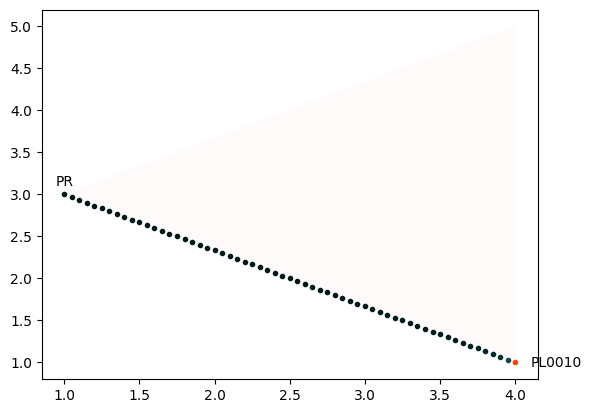

In [117]:
test_wiring_segment(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(0,0,1,0),
    Box2_name = "PL0010",
    box_grid_size = 60,
    max_box_power = 1000,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

In [124]:
def test_wiring_triangle(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                if value != 0.75:
                    for l in range(max_box_power):
                        if color_point != "orangered":
                            break
                        Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                        value = float(non_local_boxes.evaluate.h_flat(Q))
                        if value > threshold:
                            color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()


0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.75
0.75
0.75
0.75
0.7499999403953552
0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.75
0.75
0.75
0.7500000596046448
0.75
0.75
0.75
0.75
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.75
0.7499999403953552
0.75
0.75
0.7500000596046448
0.7500000596046448
0.7500000596046448
0.7500000596046448
0.7500000596046448
0.75
0.75
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.75
0.75
0.75
0.7500000596046448
0.7500000596046448
0.7500000596046448
0.7500000596046448
0.7500001192092896
0.7500000596046448
0.7499999403953552
0.7499998807907104
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.7499999403953552
0.75
0.75
0.7541667222976685
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667

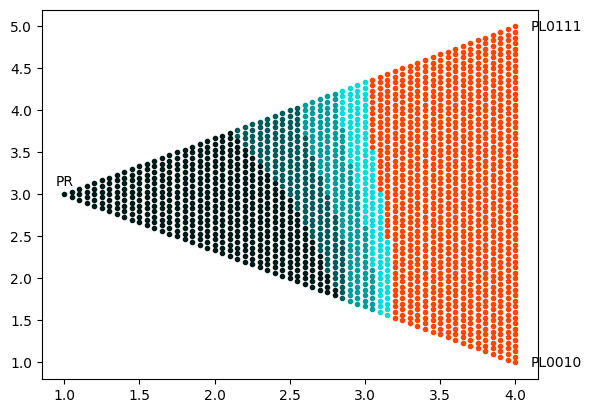

In [130]:
test_wiring_triangle(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(0,0,1,0),
    Box2_name = "PL0010",
    Box3=non_local_boxes.utils.P_L(0,1,1,1),
    Box3_name = "PL0111",
    box_grid_size = 60,
    max_box_power = 7,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.75
0.75
0.75
0.75
0.7499999403953552
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.75
0.75
0.7499999403953552
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.7500000596046448
0.7499999403953552
0.7499999403953552
0.75
0.75
0.75
0.75
0.75
0.75
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541667222976685
0.7541666626930237
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541667222976685
0.7541666626930237
0.7541667222976685
0.7541666626930237
0.7541666626930237
0.7541667222976685
0.7541667222976685
0.7541666626930237
0.7541666626930237
0.75416666269

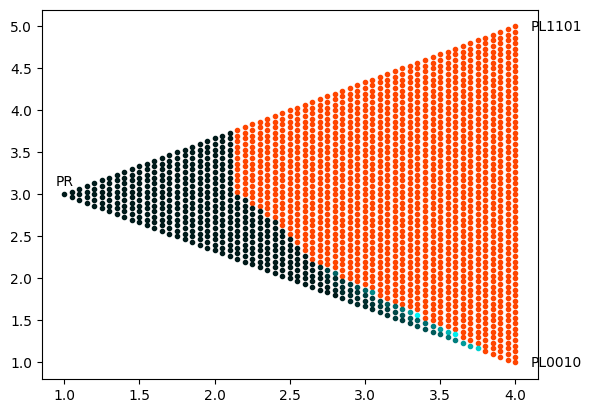

In [133]:
test_wiring_triangle(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(0,0,1,0),
    Box2_name = "PL0010",
    Box3=non_local_boxes.utils.P_L(1,1,0,1),
    Box3_name = "PL1101",
    box_grid_size = 60,
    max_box_power = 50,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

# Search on another segment

 ----- Run number  0
0.75000006
0.75
0.75
0.74999994
0.7499098
0.7483731
0.74862546
0.74891925
0.7511575
0.75633186
0.757783
0.75794107
0.7521143
0.75257325
0.7599529
0.7618797
0.759878
0.7561383
0.7538007
0.7518837
0.76739997
0.76458305
0.76229376
0.76044315
0.77288413
0.7749999
0.7749999
0.7749999
0.77716404
0.775535
0.7737094
0.772263
0.7798312
0.780211
0.7804547
0.7807069
0.7810584
0.7825908
0.7833637
0.78405076
0.7883432
0.78752476
0.7874985
0.7874984
0.7905177
0.78982496
0.7894073
0.7895689
0.8187018
0.8063707
0.8195003
0.81401384
0.80884707
0.79268795
0.8099905
0.80336696
0.8350285
0.82475084
0.7927021
0.7917378
0.82926214
0.8199257
0.8309958
0.82486904
0.842274
0.83454305
0.84826386
0.8387752
0.8569206
0.84194446
0.8586417
0.843428
0.85850453
0.8347952
0.84973985
0.83550906
0.85296065
0.83794034
0.85150784
0.83594644
0.8693647
0.8689993
tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0122, 0.0122, 1.0000, 1.0000,

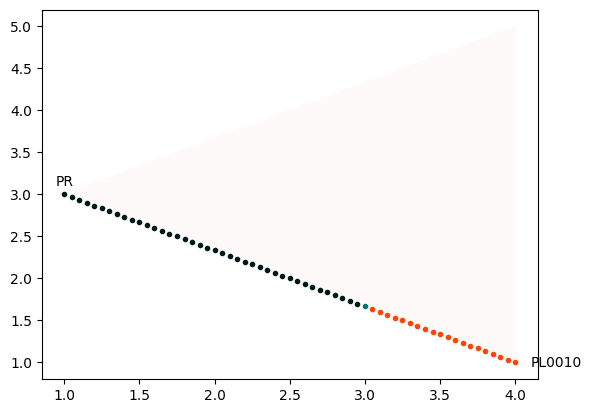

In [135]:
draw_segment_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(1,0,0,0),
    Box2_name = "PL1000",
    box_grid_size = 60,
    max_box_power_GD = 5,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 1
)

In [137]:
W_result = torch.tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0122, 0.0122, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000])
W_result

tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0122, 0.0122, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000])

0.75
0.7541667819023132
0.7583332657814026
0.7625000476837158
0.7666666507720947
0.770833432674408
0.7749999165534973
0.7791666984558105
0.7833333015441895
0.7875000238418579
0.791666567325592
0.7958333492279053
0.7999999523162842
0.8041666746139526
0.8083332180976868
0.8125
0.8166667819023132
0.8208332657814026
0.8250000476837158
0.8291666507720947
0.833333432674408
0.8374999165534973
0.8416666984558105
0.8458333015441895
0.8500000238418579
0.854166567325592
0.8583333492279053
0.8624999523162842
0.8666666746139526
0.8708332180976868
0.875
0.8791666030883789
0.8833333253860474
0.8875000476837158
0.8916666507720947
0.8958333730697632
0.8999999761581421
0.9041666984558105
0.9083333015441895
0.9125000238418579
0.9166666269302368
0.9208333492279053
0.9249999523162842
0.9291666746139526
0.9333333969116211
0.9375
0.9416666030883789
0.9458333253860474
0.9500000476837158
0.9541666507720947
0.9583333730697632
0.9624999761581421
0.9666666984558105
0.9708333015441895
0.9750000238418579
0.97916662

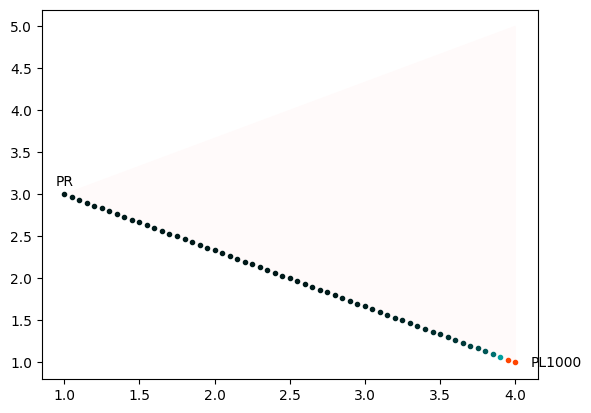

In [139]:
test_wiring_segment(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(1,0,0,0),
    Box2_name = "PL1000",
    box_grid_size = 60,
    max_box_power = 100,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7499999403953552
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.7500000596046448
0.7499999403953552
0.75
0.75
0.75
0.7499999403953552
0.7499999403953552
0.75
0.75
0.7541667819023132
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541666626930237
0.7541667819023132
0.7541666626930237
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541667222976685
0.7541666626930237
0.7541666626930237
0.7541666626930237
0.7541667222976685
0.754166722297668

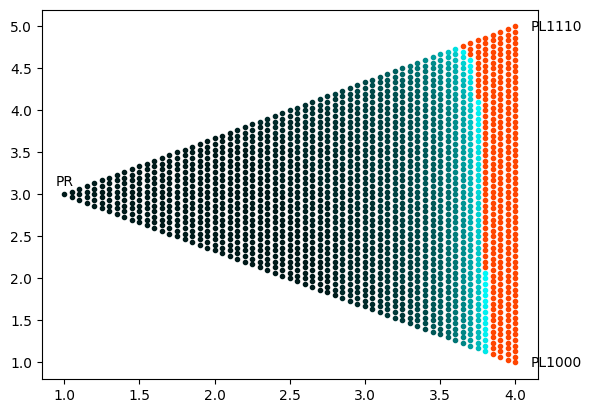

In [147]:
test_wiring_triangle(
    W = W_result,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_L(1,0,0,0),
    Box2_name = "PL1000",
    Box3=non_local_boxes.utils.P_L(1,1,1,0),
    Box3_name = "PL1110",
    box_grid_size = 60,
    max_box_power = 30,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)